In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from tqdm import tqdm

from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

In [2]:
filename = '/Users/xies/OneDrive - Stanford/Bioinformatics/Fkh RNAseq/Fkh_Mass_Spec_edited.csv'
df = pd.read_csv(filename)
df.columns
df = df.rename(columns={'Gene names  (ordered locus )':'gene_name'})
df['gene_name'] = df['gene_name'].astype(str)
df = df.drop_duplicates(subset='gene_name')
df = df.set_index('gene_name')
df = df.drop('nan')

<Axes: xlabel='exp1', ylabel='exp2'>

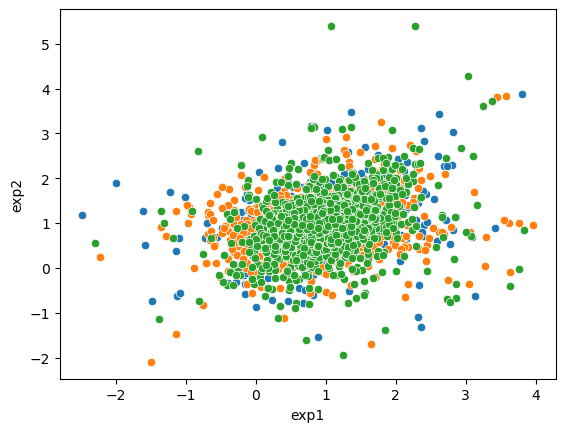

In [3]:

wt_slopes = df[['WT_Slope_Expt1','WT_Slope_Expt2']]
wt_slopes = wt_slopes.rename(columns={'WT_Slope_Expt1':'exp1','WT_Slope_Expt2':'exp2'})
fkh1_slopes = df[['fkh1_Slope_Expt1','fkh1_Slope_Expt2']]
fkh1_slopes = fkh1_slopes.rename(columns={'fkh1_Slope_Expt1':'exp1','fkh1_Slope_Expt2':'exp2'})
fkh2_slopes = df[['fkh2_Slope_Expt1','fkh2_Slope_Expt2']]
fkh2_slopes = fkh2_slopes.rename(columns={'fkh2_Slope_Expt1':'exp1','fkh2_Slope_Expt2':'exp2'})

sb.scatterplot(wt_slopes,x='exp1',y='exp2')
sb.scatterplot(fkh1_slopes,x='exp1',y='exp2')
sb.scatterplot(fkh2_slopes,x='exp1',y='exp2')


<Axes: xlabel='fkh2_del', ylabel='fkh1_del'>

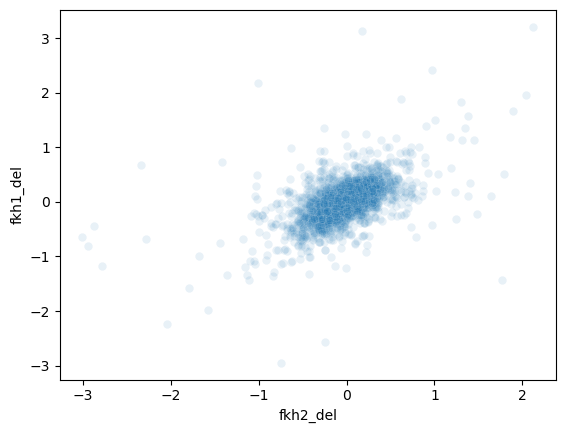

In [4]:
delta_slopes = pd.DataFrame()
delta_slopes['WT'] = df['WT_Slope_Avg']
delta_slopes['fkh1_del'] = df['WT_Slope_Avg'] - df['fkh1_Slope_Avg']
delta_slopes['fkh2_del'] = df['WT_Slope_Avg'] - df['fkh2_Slope_Avg']

sb.scatterplot(delta_slopes,x='fkh2_del',y='fkh1_del',alpha=0.1)

In [6]:
# Grab promoter sequences

from random import sample
from os import path
from re import findall
import matplotlib.pyplot as plt
from glob import glob

from pyfaidx import Fasta

dirname = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Bioinformatics/Whi5/'

#23288841 is Sc assemblyID
yeast_genome = glob(path.join(dirname,f'Genomes/23288841/GCF_000146045.2_R64_genomic.fa'))
yeast_genome = Fasta(yeast_genome[0])

# All promoters from SCG
promoters = glob(path.join(dirname,f'all_S228C_ORFs/orf_genomic_1000_all.fasta'))
promoters = Fasta(promoters[0])
                     
Fkh = pd.read_csv(path.join(dirname,'FKH2_pwm.txt'),sep='\t',index_col=0,header=None).T

def get_pswm_score(mat,seq):
    L = len(mat)
    N = len(seq)
    return np.array([ np.sum([mat.loc[k,v] for k,v in enumerate( list(seq[i:i+L]) )]) for i in range(N-L) ])


In [7]:
higher_slope_12 = delta_slopes[(delta_slopes['fkh1_del'] > 0.5) & (delta_slopes['fkh2_del'] > 0.5)]
middle_slope_12 = delta_slopes[(delta_slopes['fkh1_del'] > -0.01) & (delta_slopes['fkh2_del'] < 0.01)]
lower_slope_12 = delta_slopes[(delta_slopes['fkh1_del'] < -0.5) & (delta_slopes['fkh2_del'] < -0.5)]

promoters['YOR385W']

higher_slope_promoters = [SeqRecord( Seq(promoters[name][:1000].seq), id=name) for name,_ in higher_slope_12.iterrows()]

lower_slope_promoters = [SeqRecord( Seq(promoters[name][:1000].seq), id=name) for name,_ in lower_slope_12.iterrows()]

middle_slope_promoters = [SeqRecord( Seq(promoters[name][:1000].seq), id=name) for name,_ in middle_slope_12.iterrows()
                         if not name == 'R0020C']


In [8]:
# Export top and bottom for MEME discovery
from Bio import SeqIO

SeqIO.write(higher_slope_promoters, '/Users/xies/OneDrive - Stanford/Bioinformatics/Fkh RNAseq/Fkh12del_higher_slopes.fasta', "fasta")
SeqIO.write(lower_slope_promoters, '/Users/xies/OneDrive - Stanford/Bioinformatics/Fkh RNAseq/Fkh12del_lower_slopes.fasta', "fasta")
SeqIO.write(middle_slope_promoters, '/Users/xies/OneDrive - Stanford/Bioinformatics/Fkh RNAseq/Fkh12del_middle_slopes.fasta', "fasta")

806

In [58]:
# Load PSWM for Fkh1
Fkh = pd.read_csv(path.join(dirname,'FKH1_pwm.txt'),sep='\t',index_col=0,header=None).T
entropy = -np.sum(Fkh*np.log(Fkh),axis=1)
high_entropy_positions = [1,2,10,11,12]
Fkh = Fkh.drop(labels=high_entropy_positions).reset_index().drop(columns='index')
L = len(Fkh)

# 'promoters' is from SGD with 1000 upstream of every ORF; per JK, trimmed to 500bp upstream of TSS
for gene in tqdm(delta_slopes.index):
    if gene in promoters.keys():
        seq = promoters[gene][500:1000].seq
#        df.loc[gene,'Fkh1 score'] = get_pswm_score(Fkh,seq).mean()
        delta_slopes.loc[gene,'Fkh1 score'] = get_pswm_score(Fkh,seq).mean()

# Load PSWM for Fkh2
Fkh = pd.read_csv(path.join(dirname,'FKH2_pwm.txt'),sep='\t',index_col=0,header=None).T
entropy = -np.sum(Fkh*np.log(Fkh),axis=1)
high_entropy_positions = [1,2,10,11,12]
Fkh = Fkh.drop(labels=high_entropy_positions).reset_index().drop(columns='index')
L = len(Fkh)

# 'promoters' is from SGD with 1000 upstream of every ORF; per JK, trimmed to 500bp upstream of TSS
for gene in tqdm(delta_slopes.index):
    if gene in promoters.keys():
        seq = promoters[gene][500:1000].seq
#        df.loc[gene,'Fkh2 score'] = get_pswm_score(Fkh,seq).mean()
        delta_slopes.loc[gene,'Fkh2 score'] = get_pswm_score(Fkh,seq).mean()

100%|██████████████████████████████████████| 3978/3978 [00:36<00:00, 108.80it/s]


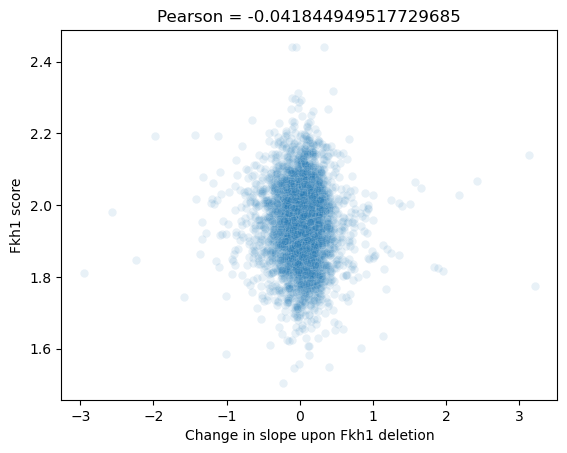

In [65]:
sb.scatterplot(delta_slopes,x='fkh1_del',y='Fkh1 score',alpha=0.1)
R,P = np.corrcoef(delta_slopes.dropna()['fkh1_del'],delta_slopes.dropna()['Fkh1 score'])
plt.title(f'Pearson = {R[1]}')
plt.xlabel('Change in slope upon Fkh1 deletion')
plt.savefig('/Users/xies/OneDrive - Stanford/Bioinformatics/Fkh RNAseq/delta_slope_1del_v_1score.svg', format='svg')
plt.savefig('/Users/xies/OneDrive - Stanford/Bioinformatics/Fkh RNAseq/delta_slope_1del_v_1score.png', format='png')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


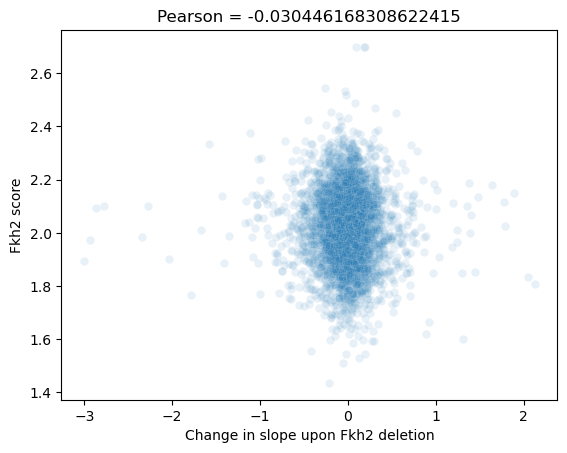

In [64]:
sb.scatterplot(delta_slopes,x='fkh2_del',y='Fkh2 score',alpha=0.1)
R,P = np.corrcoef(delta_slopes.dropna()['fkh2_del'],delta_slopes.dropna()['Fkh2 score'])
plt.title(f'Pearson = {R[1]}')
plt.xlabel('Change in slope upon Fkh2 deletion')
plt.savefig('/Users/xies/OneDrive - Stanford/Bioinformatics/Fkh RNAseq/delta_slope_2del_v_2score.png', format='png')
plt.savefig('/Users/xies/OneDrive - Stanford/Bioinformatics/Fkh RNAseq/delta_slope_2del_v_2score.eps', format='eps')

In [61]:
'''

Truncate the motifs to ~AAACA

'''

# Load PSWM for Fkh1
Fkh = pd.read_csv(path.join(dirname,'FKH1_pwm.txt'),sep='\t',index_col=0,header=None).T
entropy = -np.sum(Fkh*np.log(Fkh),axis=1)
high_entropy_positions = [1,2,3,4,10,11,12]
Fkh = Fkh.drop(labels=high_entropy_positions).reset_index().drop(columns='index')
L = len(Fkh)

#print logo
#from Bio import motifs
Fkh # AACAA

for gene in tqdm(delta_slopes.index):
    if gene in promoters.keys():
        seq = promoters[gene][500:1000].seq
#        df.loc[gene,'Truncated Fkh1 score'] = get_pswm_score(Fkh,seq).mean()
        delta_slopes.loc[gene,'Truncated Fkh1 score'] = get_pswm_score(Fkh,seq).mean()

100%|██████████████████████████████████████| 3978/3978 [00:28<00:00, 141.13it/s]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


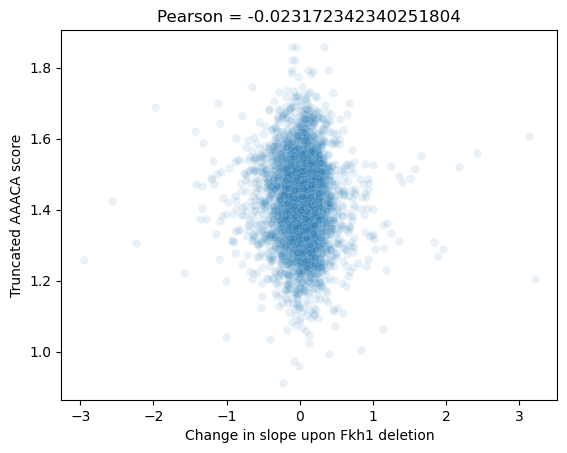

In [63]:
sb.scatterplot(delta_slopes,x='fkh1_del',y='Truncated Fkh1 score',alpha=0.1)
R,P = np.corrcoef(delta_slopes.dropna()['fkh2_del'],delta_slopes.dropna()['Truncated Fkh1 score'])
plt.title(f'Pearson = {R[1]}')
plt.ylabel('Truncated AAACA score')
plt.xlabel('Change in slope upon Fkh1 deletion')
plt.savefig('/Users/xies/OneDrive - Stanford/Bioinformatics/Fkh RNAseq/delta_slope_2del_v_AAACAscore.png', format='png')
plt.savefig('/Users/xies/OneDrive - Stanford/Bioinformatics/Fkh RNAseq/delta_slope_2del_v_AAACAscore.eps', format='eps')

In [123]:
'''

Load all motifs

'''

from glob import glob
from os import path

filenames = glob('/Users/xies/OneDrive - Stanford/Bioinformatics/Fkh RNAseq/All_PWMs/ALIGNED_ENOLOGO_FORMAT_PWMS/*.pwm')
motifs = {}

for f in filenames:
    basename = path.splitext(path.split(f)[1])[0]
    tf_name,motif_name = basename.split('_')
    _df = pd.read_csv(f,sep='\t',index_col=0, header=None).T.reset_index(drop=True)
    motifs[(tf_name,motif_name)] = _df


In [124]:
_df

,A,T,G,C
0,-0.229252,-0.431229,0.419309,0.404882
1,-0.187044,-0.432302,0.432663,0.346102
2,-0.171339,-0.532013,0.607065,0.217537
3,-0.090165,-0.681670,0.688238,0.140014
4,-0.049950,-0.699163,0.641892,0.165803
5,-0.049346,-0.842828,0.642496,0.281822
6,-0.284150,-0.861228,0.797220,0.364411
7,0.082986,-1.806945,1.149928,-0.235059
8,-2.715026,0.877285,-1.979903,0.818925
9,-0.472614,0.046756,0.031677,0.464486


In [125]:
# Find tf that has maximum motifID (don't know how it's ordered)

motif_manifest = pd.DataFrame()
motif_manifest['Gene name'] = [g for g,m in motifs.keys()]
motif_manifest['MotifID'] = [m for g,m in motifs.keys()]

grouped = [m for gene_name, m in motif_manifest.groupby('Gene name')]
idx = np.array([[g['MotifID'].argmax()] for g in grouped]).squeeze()
motifs2run = motif_manifest.loc[idx].reset_index()

print(f'Total of {len(motif_manifest)} motifs for {len(motifs2run)} TFs')

Total of 1887 motifs for 259 TFs


In [ ]:
# Do run motif score and correlat with slope change

motif_correlations = pd.DataFrame(columns=['Fkh1del_correlation','Fkh2del_correlation'],
                                 index=motifs2run['Gene name'])

for _,m in tqdm(motifs2run.iterrows()):
    gene_name = m['Gene name']
    motifID = m['MotifID']
    motif = motifs[(gene_name,motifID)]

    scores = np.array([ get_pswm_score(motif, promoters[gene][500:1000].seq)
                      for gene in delta_slopes.dropna().index if gene in promoters.keys()])
    
    R,P = np.corrcoef(scores,delta_slope['fkh1_del'])
    motif_correlations.loc[gene_name, 'Fkh1del_correlation'] = R
    R,P = np.corrcoef(scores,delta_slope['fkh2_del'])
    motif_correlations.loc[gene_name, 'Fkh2del_correlation'] = R

0it [00:00, ?it/s]

In [130]:
get_pswm_score(motif,seq).mean()

np.float64(-5.798067645106984)

In [131]:
scores

array(3971)